In [2]:
# load some packages
from matplotlib.text import Text
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import oat_python as oat
from collections import Counter


/Users/floyd/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
pd.read_csv(
        'https://www.dropbox.com/scl/fi/ccpg44dt73ga24p45a0u3/collaborations_Zoology_608.csv.gz?rlkey=8kr35ztwfztz36qww7v1fr926&st=xcxd6s6d&dl=1',
        compression='gzip',
    )

,article_id,year,researcher_id
0,pub.1100184428,2018.0,ur.07500112735.28
1,pub.1100184428,2018.0,ur.0775274140.76
2,pub.1014429482,2008.0,ur.012645135765.17
3,pub.1014429482,2008.0,ur.016413706041.84
4,pub.1071171019,1994.0,ur.01216432663.31
...,...,...,...
1134648,pub.1028766873,2008.0,ur.0747722674.67
1134649,pub.1063382447,2016.0,ur.01114402740.30
1134650,pub.1063382447,2016.0,ur.01137537003.00
1134651,pub.1063382447,2016.0,ur.0577704134.35


In [4]:
pd.read_csv(
        'https://www.dropbox.com/scl/fi/0bsgnsgb1rr1s143cgyd1/articles_Zoology_608.csv.gz?rlkey=emlv5fy52dz0d2rnodygjy9pp&st=kehlrig7&dl=1',
        compression = 'gzip',
    ).columns

/var/folders/v9/_js75nzx64lf8__fmfsscg4c0000gn/T/ipykernel_28909/2360218702.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,12,20) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


Index(['article_id', 'year', 'date', 'doi', 'volume', 'issue', 'pages',
       'title_preferred', 'abstract_preferred', 'journal_title',
       'citations_count', 'metrics_times_cited', 'metrics_recent_citations',
       'metrics_field_citation_ratio', 'metrics_relative_citation_ratio',
       'altmetrics_score', 'nauthors', 'npatents_citing',
       'ncategory_for_l1_codes', 'ncategory_for_l2_codes',
       'pg_abstract_preferred_lang_code', 'pg_abstract_preferred_lang_conf'],
      dtype='object')

In [5]:
# load the data
df = pd.read_csv(
        'https://www.dropbox.com/scl/fi/a1t16rtialcw03n50ffkc/concepts_Zoology_608.csv.gz?rlkey=vjv60sfbhofbgvzfzdkrlurl1&st=ciu77f72&dl=1',
        compression='gzip',
    )

df

,article_id,year,concept,relevance_mean,concept_freq_in_abstract,concept_no,dfreq_in_category_for_2l,dfreq_in_category_for_2l_year
0,pub.1050083629,1984,mfvsg,0.0,1,0,2,1
1,pub.1050083629,1984,svsg,0.0,1,1,1,1
2,pub.1091469564,1992,1972 random parasitoid model,0.0,1,0,1,1
3,pub.1117742847,2001,198697 lobster research cruise,0.0,1,0,1,1
4,pub.1043257859,2001,1986–97 lobster research cruise,0.0,1,0,2,2
...,...,...,...,...,...,...,...,...
18064866,pub.1000238039,2015,’s worker population size,0.0,1,40,1,1
18064867,pub.1005449634,2012,’s workforce swarm fraction depart,0.0,1,42,1,1
18064868,pub.1134463678,2021,’s bad crop pest,0.0,1,57,1,1
18064869,pub.1083920773,2017,’s bad invasive,0.0,1,54,1,1


In [6]:
# config
MIN_RELEVANCE = 0.7
MIN_YEAR = 1920
MAX_YEAR = 2021  # when the data is from
MIN_CONCEPT_FREQ = 0.0001
MAX_CONCEPT_FREQ = 0.001

# relevance filtering
df = df[df['relevance_mean'] >= MIN_RELEVANCE]

# year filtering
df = df[df['year'] >= MIN_YEAR]

# counts
num_articles = df['article_id'].nunique()
concept_freq = df.groupby('concept').transform('size') / num_articles
df = df[(concept_freq >= MIN_CONCEPT_FREQ) & (concept_freq <= MAX_CONCEPT_FREQ)]

# remove columns we dont care about
df = df[['article_id', 'concept', 'year']]

df

,article_id,concept,year
18622,pub.1039451177,akh receptor,2002
18623,pub.1129686695,akh receptor,2020
18624,pub.1007326462,akh receptor,2006
18625,pub.1101015253,akh receptor,2018
49772,pub.1092160858,acromyrmex leaf cut ant,2017
...,...,...,...
18063221,pub.1010904311,γδ t cell,2012
18063223,pub.1039368032,γδ t cell,2014
18063225,pub.1120146611,γδ t cell,2019
18063226,pub.1040144066,γδ t cell,2012


In [7]:
# get the last publication
def conceptprocess(df):
    concepts = (
        df
            .sort_values('year')
            .drop_duplicates(subset='concept', keep='first')
            .reset_index(drop=True)
    )
    # normalize the year
    concepts['norm_year'] = (concepts['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)
    return(concepts)

conceptprocess(df)

,article_id,concept,year,norm_year
0,pub.1070547478,land bird,1920,0.000000
1,pub.1005636163,fruit tree,1921,0.009901
2,pub.1070548561,american museum,1922,0.019802
3,pub.1070548072,bird conservation,1922,0.019802
4,pub.1054807332,ministry of agriculture,1923,0.029703
...,...,...,...,...
4141,pub.1122800167,free plain language summary,2019,0.980198
4142,pub.1112852989,sustainable development goals,2019,0.980198
4143,pub.1125125078,invasive non native specie,2020,0.990099
4144,pub.1131427185,student learning,2020,0.990099


In [8]:
def edgeprocess(df):
    edges = df.merge(df, on=['article_id', 'year'], suffixes=['_source', '_target'])
    edges = edges[edges['concept_source'] < edges['concept_target']]
    edge_counts = (
        edges.groupby(['concept_source', 'concept_target'])
             .size()
             .reset_index(name='count')
    )
    max_count = edge_counts['count'].max()
    edge_counts['inv_count'] = max_count - edge_counts['count'] + 1
    return edge_counts

edgeprocess(df)

,concept_source,concept_target,count,inv_count
0,abiotic factor,abundance of insect,1,20
1,abiotic factor,different insect pollinator,1,20
2,abiotic factor,invertebrate community,1,20
3,abiotic factor,non bee insect,1,20
4,abiotic factor,non target invertebrate,1,20
...,...,...,...,...
22851,worker bee,worker larvae,1,20
22852,worker reproduction,worker sterility,1,20
22853,worker reproduction,young larvae,2,19
22854,xenopus tropicalis,zinc finger transcription factor,1,20


In [9]:
def networkprocess(df):
    concepts = conceptprocess(df)
    edges = edgeprocess(df)

    G = nx.Graph()

    G.add_nodes_from([(c, {'weight': 1.0}) for c in concepts['concept']])
    
    G.add_edges_from([(u, v, {'weight': inv}) for u, v, inv in zip(edges['concept_source'], edges['concept_target'], edges['inv_count'])])
    
    return G


G = networkprocess(df)

/Users/floyd/anaconda3/lib/python3.11/site-packages/scipy/sparse/_compressed.py:956: RuntimeWarning: invalid value encountered in cast
  x = np.atleast_1d(np.asarray(values, dtype=self.dtype)).ravel()


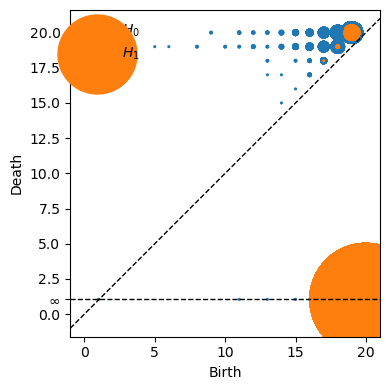

In [10]:
def processhomo(df):
    G = networkprocess(df)
    adj = nx.adjacency_matrix(G)
    node_mins = []
    for node in G.nodes():
        neighbor_weights = [edata['weight'] for _, _, edata in G.edges(node, data=True)]
        if neighbor_weights:
            node_mins.append(min(neighbor_weights))
        else:
            node_mins.append(np.inf)  # no neighbors

    adj.setdiag(node_mins)
    adj = adj.sorted_indices()

    # oat calculation
    factored = oat.rust.FactoredBoundaryMatrixVr(adj, 1)
    homology = factored.homology(True, True)
    return homology

def persistentdiag(homology, title=None, zoom_range=None):

    # initialize the plot
    fig, ax = plt.subplots()
    fig.set_figheight(4)
    fig.set_figwidth(4)
    infty = 1.05
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')
    ax.axis('equal')

    if zoom_range:
        ax.set_xlim(*zoom_range)
        ax.set_ylim(*zoom_range)
        infty = max(*zoom_range)+0.02

    # lines
    ax.axhline(infty, ls='--', c='k', lw=1)
    ax.axline([0, 0], [1, 1], ls='--', c='k', lw=1)

    homology_fixed = homology.copy()
    homology_fixed['death'] = homology_fixed['death'].replace(np.inf, infty)
    points = list(zip(homology_fixed['birth'], homology_fixed['death'], homology_fixed['dimension']))
    count = Counter(points)
    homology_fixed['count'] = [count[(b, d, dim)] for b, d, dim in zip(homology_fixed['birth'],
                                                                  homology_fixed['death'],
                                                                  homology_fixed['dimension'])]
    for dim in homology_fixed['dimension'].unique():
        dim_bc = homology_fixed[homology_fixed['dimension'] == dim]
        ax.scatter(dim_bc['birth'], dim_bc['death'],
                s=dim_bc['count']*1.5,
                label=f'$H_{dim}$')

    # Y ticks
    ticks = ax.get_yticklabels()[1:-1]
    ticks.append(Text(0, infty, r'$\infty$'))  # add infty label
    ax.set_yticks(np.hstack((ax.get_yticks()[1:-1], infty)))
    ax.set_yticklabels(ticks)

    if title:
        ax.set_title(title)
    ax.legend(frameon=False)
    fig.tight_layout()
    plt.show()

persistentdiag(processhomo(df))

In [11]:
processhomo(df)

/Users/floyd/anaconda3/lib/python3.11/site-packages/scipy/sparse/_compressed.py:956: RuntimeWarning: invalid value encountered in cast
  x = np.atleast_1d(np.asarray(values, dtype=self.dtype)).ravel()


,dimension,birth,death,birth simplex,death simplex,cycle representative,cycle nnz,bounding chain,bounding nnz
id,,,,,,,,,
0,0,inf,inf,[4113],None,simplex filtration coefficient 0 [4113] ...,1,None,NaN
1,0,inf,inf,[4070],None,simplex filtration coefficient 0 [4070] ...,1,None,NaN
2,0,inf,inf,[4026],None,simplex filtration coefficient 0 [4026] ...,1,None,NaN
3,0,inf,inf,[4000],None,simplex filtration coefficient 0 [4000] ...,1,None,NaN
4,0,inf,inf,[3992],None,simplex filtration coefficient 0 [3992] ...,1,None,NaN
...,...,...,...,...,...,...,...,...,...
5103,1,18.0,19.0,"[3691, 3920]","[3563, 3691, 3920]",simplex filtration coefficient 0 [36...,4,simplex filtration coefficient ...,4.0
5104,1,18.0,19.0,"[3567, 3730]","[3567, 3691, 3730]",simplex filtration coefficient 0 [35...,4,simplex filtration coefficient ...,4.0
5105,1,18.0,19.0,"[3249, 3432]","[1136, 3249, 3432]",simplex filtration coefficient 0 [32...,5,simplex filtration coefficient ...,3.0


### Idea
Get the large holes (circles) in both year filtration and co-occurance filtration.
### Step
1. Pick the "dimension = 1" and persistence > threshold(k)
2.

In [12]:
import ast
import re

In [23]:
df_homology = processhomo(df)
max_filtration_val = 21.0

df_H1 = df_homology[df_homology['dimension'] == 1].copy()
df_H1['death_mod'] = df_H1['death'].replace(np.inf, max_filtration_val)
df_H1['persistence'] = df_H1['death_mod'] - df_H1['birth']

df_H1_sorted = df_H1.sort_values(by=['persistence', 'birth'], ascending=[False, True])


#largest persistent
target_bar = df_H1_sorted.iloc[0]
print(f"Selected bar: birth={target_bar['birth']}, death={target_bar['death']}, persistence={target_bar['persistence']}")

pattern_all = r"\[([0-9,\s]+)\]"
matches = re.findall(pattern_all, str(target_bar['cycle representative']))

edge_list = []
for m in matches:
    nodes = list(map(int, m.strip().split(',')))
    if len(nodes) == 2:
        edge_list.append(tuple(nodes))
    elif len(nodes) > 2:
        edge_list.extend([(nodes[i], nodes[(i+1)%len(nodes)]) for i in range(len(nodes))])

node_set = set([n for edge in edge_list for n in edge])
print("Nodes involved in generator:", node_set)
print("Edges:", edge_list)


/Users/floyd/anaconda3/lib/python3.11/site-packages/scipy/sparse/_compressed.py:956: RuntimeWarning: invalid value encountered in cast
  x = np.atleast_1d(np.asarray(values, dtype=self.dtype)).ravel()


Selected bar: birth=19.0, death=inf, persistence=2.0
Nodes involved in generator: {1157, 510, 2061, 1934, 2703, 3984, 3603, 1051, 2722, 175, 1074, 57, 3270, 596, 360, 3432, 875, 1390, 1136, 625, 756, 3572, 1274, 125, 3838}
Edges: [(3270, 3984), (2703, 3984), (1051, 1157), (756, 1390), (625, 3270), (360, 1274), (360, 1074), (175, 510), (125, 175), (57, 510), (2722, 3572), (1157, 1390), (1051, 1074), (875, 3838), (625, 2722), (596, 875), (57, 756), (3572, 3838), (1136, 3603), (596, 2061), (125, 2703), (3432, 3603), (1934, 2061), (1274, 3432), (1136, 1934)]


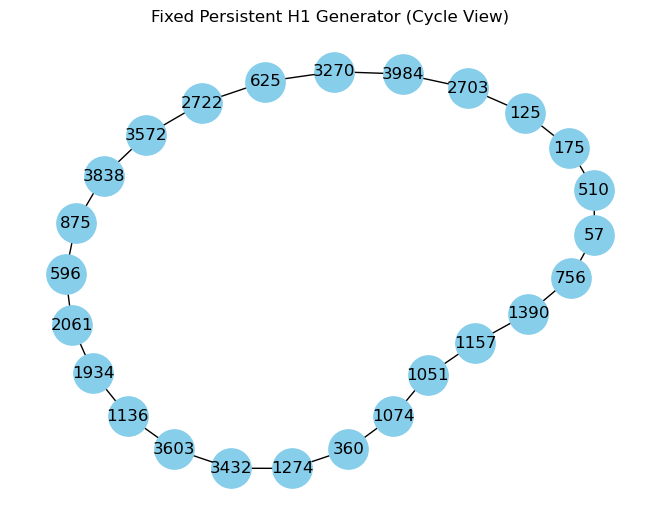

In [24]:
H = nx.Graph()
H.add_nodes_from(node_set)
H.add_edges_from(edge_list)

pos = nx.spring_layout(H, seed=42)
nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=800)
plt.title("Fixed Persistent H1 Generator (Cycle View)")
plt.axis('off')
plt.show()